In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, MeanShift, SpectralClustering, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.mixture import GaussianMixture
from sklearn.metrics import calinski_harabasz_score,silhouette_score,davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

from scipy.special import boxcox1p


#from yellowbrick.cluster import KElbowVisualizer

import seaborn as sns

from collections import Counter

from tqdm.notebook import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans

from os import listdir
import pathlib
from os.path import isfile, join

from collections import Counter

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
pd.set_option('display.max_columns', None)

### Функции для процесса

In [6]:
def metrics_cluster(data, predict_labels, algorithm):
    
    """
    Функция по рассчету метрик по кластеризации без известного ground thuth
    """
        
    df_metrics = pd.DataFrame(columns=['davies_bouldin',
                                       'size_clusters',
                                       'balance_sizes'])

    size_clusters = [round(data[predict_labels==k].shape[0]/data.shape[0],2) for k in set(predict_labels)]
    balance_sizes = np.prod(size_clusters)*100
    
    df_metrics.loc[0,:] = ([davies_bouldin_score(data,predict_labels),
                               size_clusters,
                               balance_sizes])
    return df_metrics


def gap_statistic_all_algorithm(data, nrefs=3, maxClusters=5):
    """
    Calculates KMeans optimal K using Gap Statistic 
    Params:
        data: ndarry of shape (n_samples, n_features)
        nrefs: number of sample reference datasets to create
        maxClusters: Maximum number of clusters to test for
    Returns: (gaps, optimalK)
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = pd.DataFrame({'clusterCount':[], 'gap':[]})
    
    for gap_index, k in enumerate(range(1, maxClusters)):
        
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)
    
        # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
        for i in range(nrefs):
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)
            
            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)
            
            refDisp = km.inertia_
            refDisps[i] = refDisp
            
        # Fit cluster to original data and create dispersion
        km = KMeans(k)
        km.fit(data)
        origDisp = km.inertia_
        
        # Calculate gap statistic
        gap = np.log(np.mean(refDisps)) - np.log(origDisp)
    
        # Assign this loop's gap statistic to gaps
        gaps[gap_index] = gap
        
        resultsdf = resultsdf.append({'clusterCount':k, 'gap':gap}, ignore_index=True)
    return (gaps.argmax() + 1, resultsdf)

In [7]:
# нормолайзер
def getNormTransform(data, norm_type = "zscore"):
    """
    norm_type:
        zscore: return index of best values
        standard: returen after StandardScaler
        
    # for n in ['zscore', 'standard', 'quantile', 'log_norm']:
    #     if n == 'zscore':
    #         sns.distplot(df['M_CHECK_SUM'].iloc[getNormTransform(df['M_CHECK_SUM'], norm_type = n)])
    #     else:
    #         sns.distplot(getNormTransform(df['M_CHECK_SUM'], norm_type = n))  
    #     plt.show()    
    """
    
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import quantile_transform
    
    if norm_type == 'zscore':
        zscore = (data - np.mean(data)) / np.std(data)
        return np.where(abs(zscore) <= 3)[0]
    
    if norm_type == 'standard':
        scaler = StandardScaler()
        return scaler.fit_transform(data.to_frame())
        
    if norm_type == 'quantile':
        return quantile_transform(data.to_frame(), output_distribution='normal')
    
    if norm_type == 'log_norm':
        return np.log(abs(data - np.mean(data)) / np.std(data)).replace([np.inf, -np.inf], np.nan)
    
    
def iqr_cleaner(df, col, left=None, right=None):
    """
    Интерквартильная нормализация (чистим от выбрасов)
    """
    from scipy.stats import iqr
    
    if left == None and right == None:
        left = df[col].quantile(q=0.25) - (1.5 * iqr(df[col], rng=(25,75)))
        right = df[col].quantile(q=0.75) + (1.5 * iqr(df[col], rng=(25,75)))

        norm_data_index = df[(df[col] >= left) & (df[col] <= right)].index
        
        return norm_data_index    
    
    if left != None:
        left = df[col].quantile(q=0.25) - (1.5 * iqr(df[col], rng=(25,75)))
        norm_data_index = df[(df[col] >= left)].index
    
        return norm_data_index    
    
    if right != None:
        left = df[col].quantile(q=0.25) - (1.5 * iqr(df[col], rng=(25,75)))
        norm_data_index = df[(df[col] <= right)].index
    
        return norm_data_index


# удаление переменных с малым распределением (константные значения)
def cols_bin_counts_thr(df, thr):
    """
    Выводит бинарные колонки с почти константами
    """
    
    cols_list = []
    df_tmp = df.copy()
    for col in tqdm(df.columns):
        if (df[col].nunique()==2) and ((df[col].value_counts(normalize=True)>thr).sum()!=0):
            cols_list.append(col)
    return cols_list

In [8]:
# визуалка
def comp_viz(pca, collumns:list, thr:float, ascending:bool=False, index_comp:list=None, prince=False)->None:
    """
    Визуализирует компоненты PCA
    
    вход:
        pca - обученый объект pca из библиотеки sklearn
        collumns:list - лист с фичами
        thr:float - порог, который отсекает признаки с меньшими значениями
        ascending:bool - упорядочивание по возрастанию 
        index_comp:list - индекс компонентов, которые должны визуализироваться (по умолчанию все признаки)
    
    выход:
        None
    """
    
    
    if prince:
        index_comp = range(pca.V_.shape[0])
        for i in index_comp:
            print(f'component_{i}')
            tmp = pd.DataFrame(data = pca.V_[i], index=collumns)
            tmp = tmp.sort_values(by=[0], ascending=ascending)
            tmp = tmp[(abs(tmp[0])>=thr)]
            plt.figure(i, figsize=(10,10))
            sns.heatmap(tmp, 
                        annot=True,
                        annot_kws={"size": 10},
                        cmap=sns.color_palette("RdGy_r", 10))
        
    else:
        
        if not index_comp:
            index_comp = range(pca.components_.shape[0])

        for i in index_comp:
            print(f'component_{i}')
            tmp = pd.DataFrame(data = pca.components_[i], index=collumns)
            tmp = tmp.sort_values(by=[0], ascending=ascending)
            tmp = tmp[(abs(tmp[0])>=thr)]
            plt.figure(i, figsize=(10,10))
            sns.heatmap(tmp, 
                        annot=True,
                        annot_kws={"size": 10},
                        cmap=sns.color_palette("RdGy_r", 10))

### Проверка распределений

In [9]:
from scipy import stats

def analyse_skewness(df, x):
    
    fig, ax = plt.subplots(2,2, figsize=(5,5))
    
    sns.distplot(df[x], ax=ax[0,0])
    sns.distplot(np.log(df[x]), ax=ax[0,1])
    sns.distplot(np.sqrt(df[x]), ax=ax[1,0])
    sns.distplot(stats.boxcox(df[x])[0], ax=ax[1,1])
    
    plt.tight_layout()
    plt.show()
    
    print(df[x].skew().round(2))
    print(np.log(df[x]).skew().round(2))
    print(np.sqrt(df[x]).skew().round(2))
    print(pd.Series(stats.boxcox(res['AVT'])[0]).skew().round(2))

In [10]:
# стат тесты

# тест на нормальность
def norm_test(series):
    from scipy.stats import shapiro
    from scipy.stats import anderson
    
    if len(series) > 5000:
        tmpseries = series.sample(n=4999)
        shapiro_stat, shapiro_p = shapiro(tmpseries.tolist())
        print(shapiro_stat, shapiro_p)
        
        if shapiro_p < 0.05:
            print('Reject H0')
        else:
            print('Reject H1')
        
    anderson_stat, anderson_cv, anderson_sl  = anderson(series, dist='norm')
    print(anderson_stat, anderson_cv, anderson_sl)
    if anderson_stat > all(anderson_cv):
        print('Reject H0')
    else:
        print('Reject H1')
        
        
# norm_test(np.log(df['CHECK_VALUE']+1))    

In [11]:
def dist_comparing_test(series1, series2, plot = True):
    # параметрические
    from scipy.stats import ttest_ind
    from scipy.stats import ttest_rel
    from scipy.stats import f_oneway
    
    # t test
    stat_ind, p_ind = ttest_ind(series1, series2)
    
    if p_ind < 0.05:
        print('Reject H0, series unequal')
    else:
        print('Reject H1, series equal')
    
    # парный t test, если кол-во элементов равно
    if len(series1) == len(series2):
        stat_rel, p_rel = ttest_rel(series1, series2)    

        if p_rel < 0.05:
            print('Reject H0, series unequal')
        else:
            print('Reject H1, series equal')
            
    # anova - дисперсионный анализ
    # проверка на отличие образцов данных
    f_stat, f_p = f_oneway(series1, series2)
    
    if f_p < 0.05:
        print('Reject H0, series unequal')
    else:
        print('Reject H1, series equal')
        
    if plot:
        sns.distplot(series1)
        sns.distplot(series2)
        
#dist_comparing_test(df[df['CHECK_VALUE'] < 1000]['CHECK_VALUE'],
#                    df[(df['CHECK_VALUE'] < 1000) & (df['CHECK_VALUE'] > 500)]['CHECK_VALUE'])

In [12]:
def is_dist_equal(series1, series2):
    # не параметрические
    from scipy.stats import mannwhitneyu
    from scipy.stats import wilcoxon
    from scipy.stats import kruskal
    
    mn_stat, mn_p = mannwhitneyu(series1, series2)
    if mn_p < 0.05:
        print('Reject H0, series unequal')
    else:
        print('Reject H1, series equal')
    
    if len(series1) == len(series2):
        w_stat, w_p = wilcoxon(series1, series2)
        if w_p < 0.05:
            print('Reject H0, series unequal')
        else:
            print('Reject H1, series equal')
        
    k_stat, k_p = kruskal(series1, series2)
    if k_p < 0.05:
        print('Reject H0, series unequal')
    else:
        print('Reject H1, series equal')
        
# is_dist_equal(df[df['CHECK_VALUE'] < 1000]['CHECK_VALUE'], df[(df['CHECK_VALUE'] < 1000) & (df['CHECK_VALUE'] > 500)]['CHECK_VALUE'])

### Процессы

In [13]:
# отбор кол-ва кластеров
def calcClusterCount(clear_df, minc=3, maxc = 6, viz_cols = None, viz = True):
    """
    input:
        clear_df - DF is ready to an algorithm (after feature engineering)
    """
    if viz_cols != None:
        
        z = viz_cols[0]
        o = viz_cols[1]
        viz_cols = [(list(clear_df.columns).index(z), list(clear_df.columns).index(o)),] 
    else:
        viz_cols = [(0,1),]

    # Проверяем кластеры 3-5 штук (на больше нужно больше времени или использовать MiniBatch)
    for k in tqdm(range(minc, maxc)):

        print('---------------------------------------------------------------------------')
        #обучаем модель на всех данных
        model = KMeans(n_clusters=k, random_state=777)
        model.fit(clear_df)
        print(model)

        #результат + количество по каждому кластеру
        predict_labels = model.labels_
        print(Counter(predict_labels))

        # рассчет метрик
        calinski_harabasz_score_metric = calinski_harabasz_score(clear_df,predict_labels)
        davies_bouldin_score_metric = davies_bouldin_score(clear_df,predict_labels)
        print('calinski_harabasz_score:',calinski_harabasz_score_metric)
        print('davies_bouldin_score:', davies_bouldin_score_metric)

        # визуализация кластерво по всем осям
        if viz:
            for i,j in viz_cols: 

                cmap = plt.cm.get_cmap('jet')
                plt.figure(figsize=(9,9))

                for cluster in range(k):
                    sns.scatterplot(clear_df.iloc[np.where(predict_labels==cluster)[0],i],
                                    clear_df.iloc[np.where(predict_labels==cluster)[0],j], color=cmap(cluster*100))
                plt.show()
        print('---------------------------------------------------------------------------')

In [14]:
# тестирование переменных на выбранном кол-ве кластеров
def calcClusterFact(clear_df, k=3, viz_cols = None, viz=True):
    
    if viz_cols != None:
        z = viz_cols[0]
        o = viz_cols[1]
        viz_cols = [(list(clear_df.columns).index(z), list(clear_df.columns).index(o)),] 
    else:
        viz_cols = [(0,1),]

    print('---------------------------------------------------------------------------')
    #обучаем модель на всех данных
    model = KMeans(n_clusters=k, random_state=777)
    model.fit(clear_df)
    print(model)

    #результат + количество по каждому кластеру
    predict_labels = model.labels_
    print(Counter(predict_labels))

    # рассчет метрик
    calinski_harabasz_score_metric = calinski_harabasz_score(clear_df,predict_labels)
    davies_bouldin_score_metric = davies_bouldin_score(clear_df,predict_labels)
    print('calinski_harabasz_score:',calinski_harabasz_score_metric)
    print('davies_bouldin_score:', davies_bouldin_score_metric)


    # визуализация кластерво по всем осям
    if viz:
        for i,j in viz_cols:

            cmap = plt.cm.get_cmap('jet')
            plt.figure(figsize=(9,9))

            for cluster in range(k):
                sns.scatterplot(clear_df.iloc[np.where(predict_labels==cluster)[0],i],
                                clear_df.iloc[np.where(predict_labels==cluster)[0],j], color=cmap(cluster*100))
            plt.show()
    print('---------------------------------------------------------------------------')
    
    return predict_labels, davies_bouldin_score_metric

In [15]:
# pca as features
def scaler(df):
    scaler = StandardScaler()
    return scaler.fit_transform(df)
    

def pca_feature(df, n_components):
    pc = PCA(n_components = n_components)
    pc.fit(df)
    
    print('Explained variance - ', sum(pc.explained_variance_))
    
    plt.figure(figsize=(10,10))
    plt.plot(pc.explained_variance_)
    plt.xlabel("№ components")
    plt.ylabel('Variance (%)')
    plt.show()
    
    v = np.cumsum(np.round(pc.explained_variance_ratio_, decimals = 4)*100)
    return round(pd.DataFrame({'Fact':pc.explained_variance_/ v, "Cumsum fact": v}), 2)
    
def pca_final(df, n_components):
    pc = PCA(n_components = n_components).fit(df)
    return pc.fit_transform(df)

In [16]:
###################################

In [17]:
def pcator(df, cols):
    
    tmp = scaler(df[cols].fillna(0))
    pca = PCA(n_components=3)
    pca.fit(tmp)
    # подготовка DF для обучения
    pca_df = pca.transform(df[cols].fillna(0))
    
    return pca_df

In [18]:
def prep_df(df, cols, meth):
    
    tmp = pd.DataFrame(index = df.index)
    
    if meth != 'pca':
        
        for n in cols:
            if meth == 'zscore':
                res = getNormTransform(df[n], norm_type = meth)
                tmp[n] = np.nan
                tmp[n].iloc[res] = df[n].iloc[res]

            if meth == 'quantile':
                tmp[n] = getNormTransform(df[n], norm_type = meth).reshape(1,-1)[0]

            if meth == 'box-cox':
                tmp[n] = boxcox1p(df[n], 0)

            if meth == 'standard':
                tmp[n] = getNormTransform(df[n], norm_type = meth).reshape(1,-1)[0]

            if meth == 'wo':
                tmp[n] = df[n]
    
    else:
        tmp = pcator(df, cols)
        

    return tmp

### Весь процесс в цикле

In [35]:
#formats = [('GM', 'ГМ'), ('MK', 'МК'), ('MD', 'МД')]
meths = ['pca',] 

cols = [('set 1', ['CS1_PRC', 'CS2_PRC', 'CS3_PRC', 'CS4_PRC']),]

In [36]:
df = pd.DataFrame(abs(np.random.randn(100, 4))/10, columns=['CS1_PRC', 'CS2_PRC', 'CS3_PRC', 'CS4_PRC'])
df['CUS'] = np.random.randint(1, 999, size= (100, 1))
df = df[['CUS', 'CS1_PRC', 'CS2_PRC', 'CS3_PRC', 'CS4_PRC']]
df.head()

,CUS,CS1_PRC,CS2_PRC,CS3_PRC,CS4_PRC
0,247,0.087103,0.148118,0.036555,0.142408
1,920,0.017955,0.147377,0.074987,0.077350
2,755,0.149777,0.111875,0.010399,0.051354
3,669,0.105290,0.018358,0.043916,0.110000
4,92,0.041715,0.050627,0.037865,0.208147


In [40]:
clear_df = df.copy()

Preprocessing


Generating features...


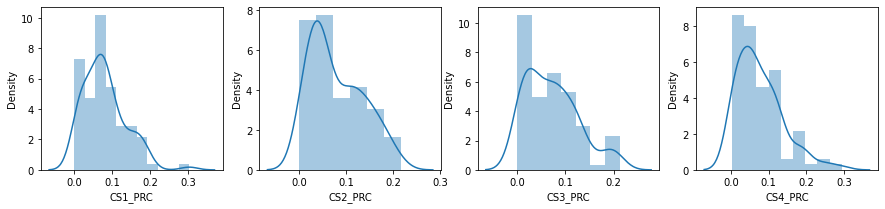

Learning ...
=======> set 1 pca <=======
(100, 3)
---------------------------------------------------------------------------
KMeans(n_clusters=3, random_state=777)
Counter({0: 35, 2: 35, 1: 30})
calinski_harabasz_score: 37.29773050946089
davies_bouldin_score: 1.2810362500109735
---------------------------------------------------------------------------
1.535817289815702


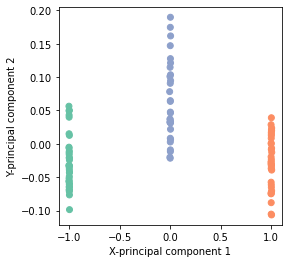

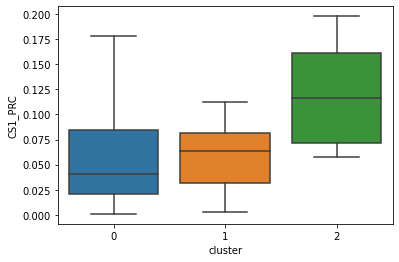

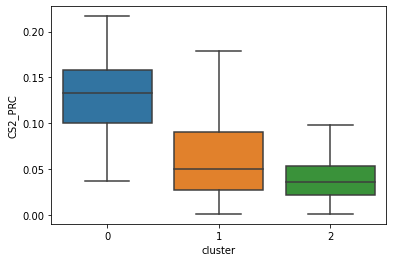

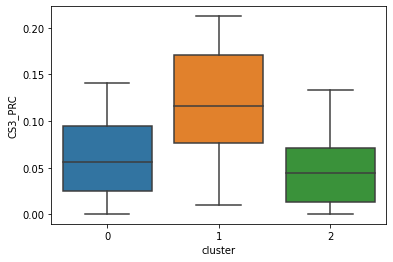

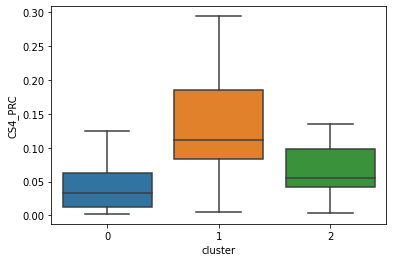

=======   =======   =======   =======
AVG SCORE - 1.2810362500109735




In [44]:
# МД - уже норм обученный (НЕ ПЕРЕЗАПУСКАТЬ!)

cols = [('set 1', ['CS1_PRC', 'CS2_PRC', 'CS3_PRC', 'CS4_PRC']),]


print('Preprocessing')



print('\n')
print('Generating features...')


fig, ax = plt.subplots(1,4, figsize=(15,3))
sns.distplot(clear_df['CS1_PRC'], ax = ax[0])
sns.distplot(clear_df['CS2_PRC'], ax = ax[1])
sns.distplot(clear_df['CS3_PRC'], ax = ax[2])
sns.distplot(clear_df['CS4_PRC'], ax = ax[3])
plt.show()


metrics = list()
for st, cls in cols:
    for meth in meths:
        pre_df = pd.DataFrame(scaler(clear_df[cls]), columns=cls)
        print('Learning ...')


        print('=======>', st, meth, '<=======')
        if meth != 'pca':
            tmp = prep_df(pre_df, cls, meth).fillna(0)
        else:
            tmp = prep_df(pre_df, cls, meth)
        print(tmp.shape)

        predict_labels, db_metric = calcClusterFact(tmp, k=3, viz = False)
        X = clear_df.copy()[['CUS', ] + cls].fillna(0)
        X['cluster'] = predict_labels
        metrics.append(db_metric)


        # формируем компоненты
        pca = PCA(n_components=2)
        X['x'] = pca.fit_transform(X[X.columns[1:]])[:,0]
        X['y'] = pca.fit_transform(X[X.columns[1:]])[:,1]

        # для построения визуализации
        customer_clusters = X[['cluster', 'x', 'y']]
        color_labels = customer_clusters['cluster'].unique()
        rgb_values = sns.color_palette("Set2", 8)
        color_map = dict(zip(color_labels, rgb_values))
        plt.subplots(figsize=(4,4))
        plt.scatter(customer_clusters['x'], customer_clusters['y'], c=customer_clusters['cluster'].map(color_map))
        plt.ylabel('Y-principal component 2')
        plt.xlabel('X-principal component 1')
        print(davies_bouldin_score(X[X.columns[1:-3]], predict_labels))
        plt.show()

        for i in cls:
            sns.boxplot(y=clear_df[i], x=X['cluster'], data=X, orient="v", showfliers = False)
            plt.show()

        print('=======   =======   =======   =======')
        print('AVG SCORE -', sum(metrics)/len(metrics))    
        print('\n')

        usrs = pd.DataFrame()
        usrs['CUS'] = clear_df['CUS']
        usrs['SEG'] = X['cluster']

        #usrs.to_csv('seg_{}_{}_{}_new23.csv'.format(en, st, meth), sep=',', header = True, index=False)
        usrs.head()
            